# Individual Conditional (ICE) Expectation plots and Accumulated Local Effects (ALE) plots

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

2021-10-27 03:47:55.798028: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


## For Regression task

Load the Boston Housing dataset.

In [2]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.boston_housing.load_data()
features = [('CRIM', 'crime_rate'), ('ZN', 'residential_zone'),
            ('INDUS', 'prop_non-retail'), ('CHAS', 'river_adjacent'),
            ('NOX', 'NO_concentration'), ('RM', 'avg_rooms'),
            ('AGE', 'age'), ('DIS', 'employment_proximit'),
            ('RAD', 'radial_highways'), ('TAX', 'tax_rate'),
            ('PTRATIO', 'pupil-teacher_ratio'), ('B', 'prop_black'),
            ('LSTAT', 'lower_status_pop')]
df_train_features = pd.DataFrame(train_features, columns=[feature[0] for feature in features])
df_train_labels = pd.DataFrame({'MEDV': train_labels})
df = pd.concat((df_train_features, df_train_labels), axis=1)

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7


In [4]:
df.CHAS = df.CHAS.apply(lambda x: 'T' if x==1.0 else 'F')

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,F,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,F,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,F,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,F,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,F,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7


In [6]:
# Numerical Variables
num_vars = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
           'TAX', 'PTRATIO', 'B', 'LSTAT']

# Categorical variables
cat_vars = ['CHAS']

X = df[num_vars + cat_vars]

# Label
y = df['MEDV']

In [7]:
# Create models
mlp_reg = MLPRegressor(hidden_layer_sizes=[300, 200, 100],
                       max_iter=700)

# Create pipeline
transformer = ColumnTransformer([
    ('numerical', MinMaxScaler(feature_range=(-1,1)), num_vars),
    ('categorical', OneHotEncoder(), cat_vars),
])

reg_pipeline = Pipeline(steps=[
    ('transform', transformer),
    ('model', mlp_reg)
])

# Create dataset
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=1337)

reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numerical',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  ['CRIM', 'ZN', 'INDUS', 'NOX',
                                                   'RM', 'AGE', 'DIS', 'RAD',
                                                   'TAX', 'PTRATIO', 'B',
                                                   'LSTAT']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['CHAS'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=[300, 200, 100],
                              max_iter=700))])

Compute the mean square error of the MLP model.

In [8]:
model_mse_error = np.sqrt(np.mean((reg_pipeline.predict(X_test) - y_test)**2))
print(f'Mean squared error of MLP model: {model_mse_error}')

Mean squared error of MLP model: 2.8372728327877708


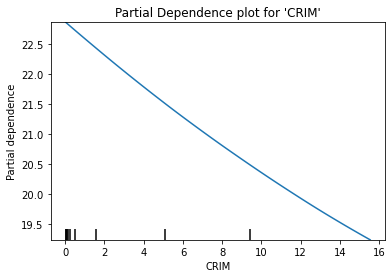

In [15]:
# First plot regular PDP
PartialDependenceDisplay.from_estimator(
    reg_pipeline, X_train, features=['CRIM'],
    kind='average'
)
plt.title("Partial Dependence plot for 'CRIM'")
plt.show()

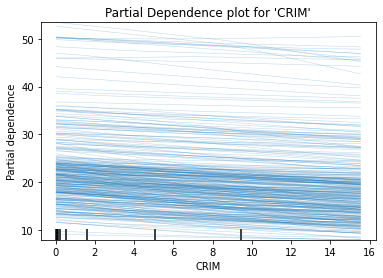

In [16]:
# Plot ICE to see indiividual examples
PartialDependenceDisplay.from_estimator(
    reg_pipeline, X_train, features=['CRIM'],
    kind='individual'
)
plt.title("Partial Dependence plot for 'CRIM'")
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 1, figsize=(10, 6))

target3_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=3, ax=ax3)
target4_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=4, ax=ax4)
target5_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=5, ax=ax5)
target6_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=6, ax=ax6)
target7_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=7, ax=ax7)
target8_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=8, ax=ax8)

ax3.set_title("Target: 3")
ax4.set_title("Target: 4")
ax5.set_title("Target: 5")
ax6.set_title("Target: 6")
ax7.set_title("Target: 7")
ax8.set_title("Target: 8")
plt.show()

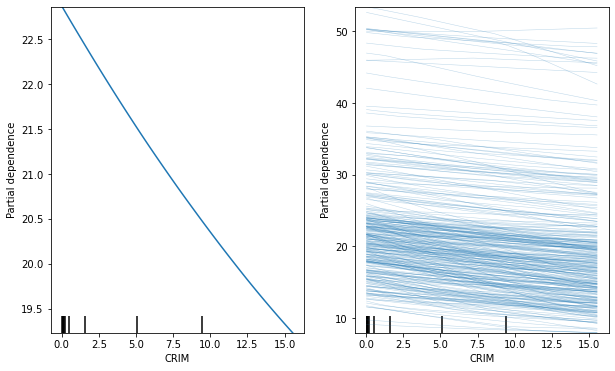

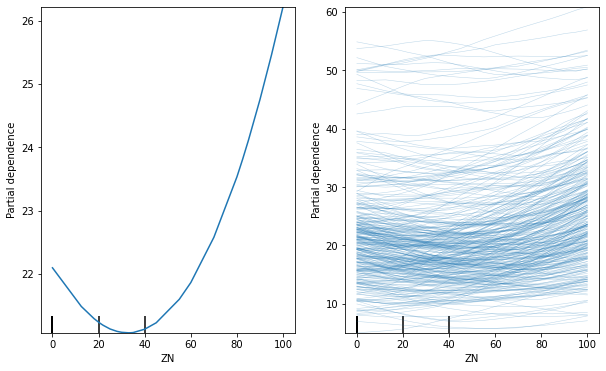

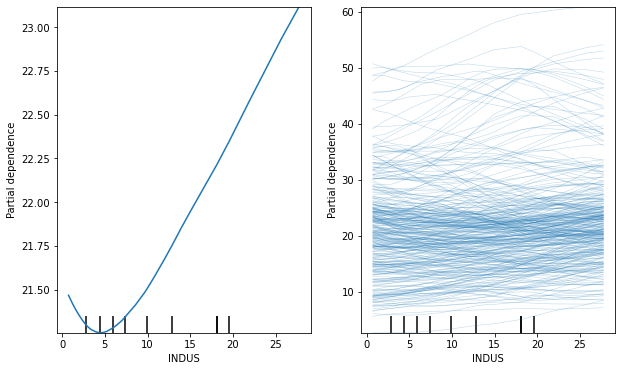

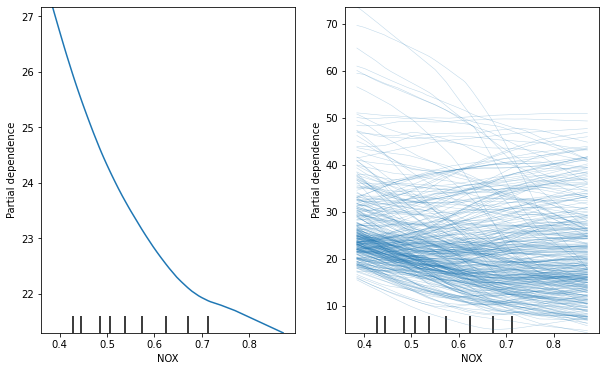

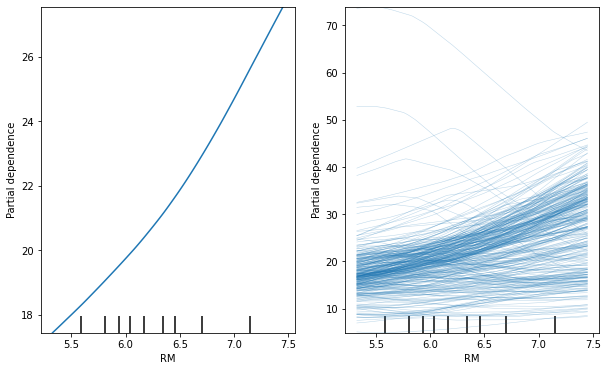

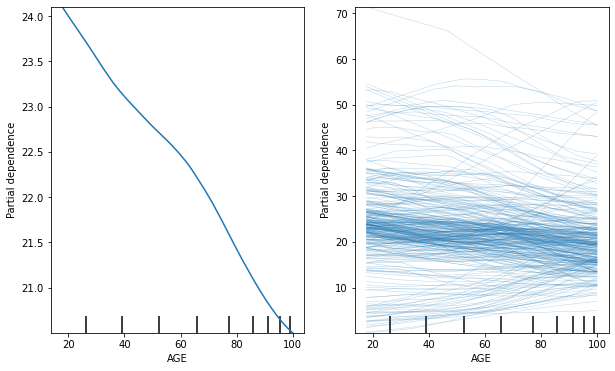

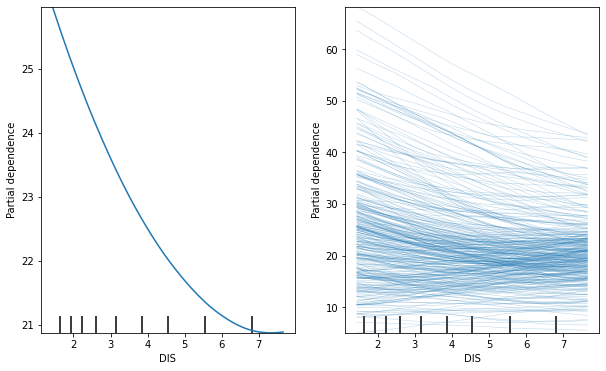

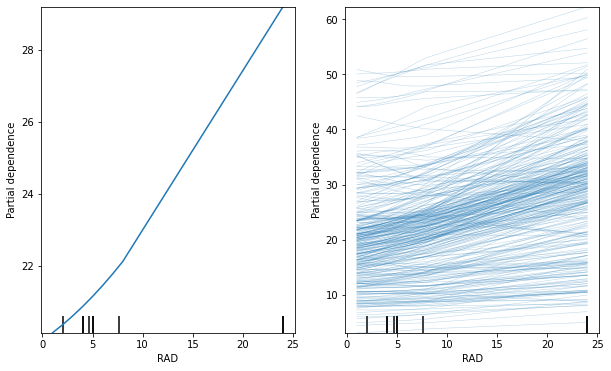

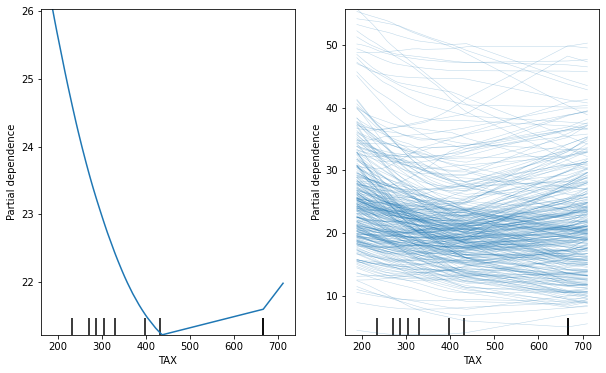

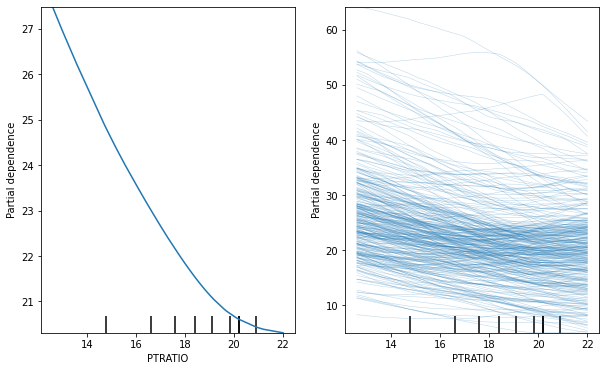

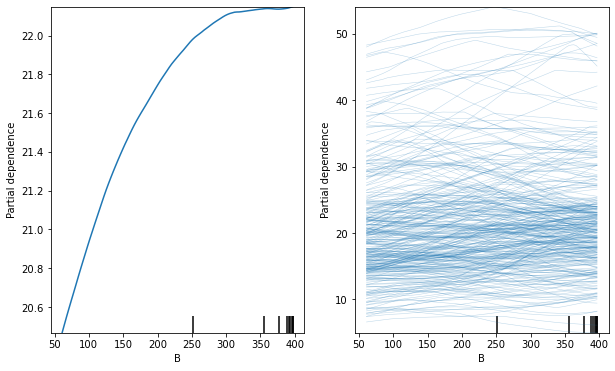

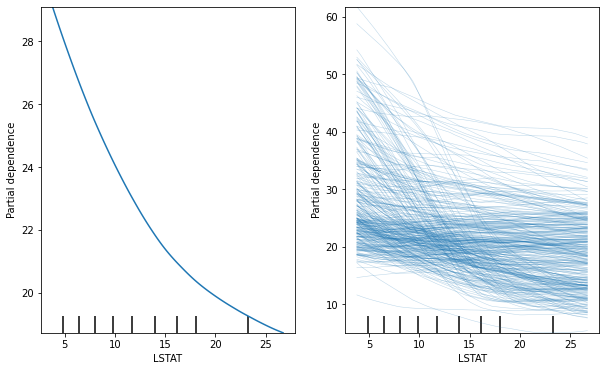

In [28]:
for feature in num_vars:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    PartialDependenceDisplay.from_estimator(
        reg_pipeline, X_train, features=[feature],
        kind='average', ax=ax1)
    PartialDependenceDisplay.from_estimator(
        reg_pipeline, X_train, features=[feature],
        kind='individual', ax=ax2)
    plt.show()

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License